# Setting up env

## Import dataset to filepath

In [1]:
#@title Import dependencies
import pandas as pd
from string import punctuation
import re
import numpy as np
import tensorflow as tf
import os
import time
import random

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

import unicodedata
import io
import pickle

In [2]:
#@title Fetching data splits

DATA_SPLITS_PKLPATH = "/content/sample_data/data_splits.pkl"

# Open the file in binary mode
with open(DATA_SPLITS_PKLPATH, 'rb') as file:
    # Call load method to deserialze
    X_train, X_val, X_test, y_train, y_val, y_test, samples_test = pickle.load(file)

# Recurrence-based Seq2Seq NMT **WITH** Bahdanau's Attention

## Step 1 - Data processing

In [3]:
#@title Functions for Preprocessing

def unicode_to_ascii(s):
  """
  normalizes accented characters into the same set of unicode, then replaces the it with their ASCII equivalent

  input: s
  """
  return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_text(text):
  s = unicode_to_ascii(text)
  s = re.sub(r"([?.!,¿])", r" \1 ", s)
  s = re.sub(r'[" "]+', " ", s)
  s = s.strip()
  return s

In [4]:
# Preprocess inputs (Spanish sentences)
train_inputs = [preprocess_text(s) for s in X_train]

# Preprocess targets (English sentences)
train_targets = [preprocess_text(s) for s in y_train]

In [5]:
print(f"{train_inputs[:3]}\n{train_targets[:3]}")

['No creo que este sea el momento ni el lugar para hablar de esto .', 'A cada uno de nosotros se nos dio trescientos dolares .', 'Ella nos gusta a todos .']
["I don't think this is the time or place to discuss this .", 'Each one of us was given three hundred dollars .', 'All of us like her .']


In [6]:
#@title Function for sentence tagging
def tag_target_sentences(sentences):
  tagged_sentences = map(lambda s: (' ').join(['<sos>', s, '<eos>']), sentences)
  return list(tagged_sentences)

In [7]:
train_tagged_targets = tag_target_sentences(train_targets)

In [8]:
train_tagged_targets[:3]

["<sos> I don't think this is the time or place to discuss this . <eos>",
 '<sos> Each one of us was given three hundred dollars . <eos>',
 '<sos> All of us like her . <eos>']

## Step 2 - Data tokenization

In [9]:
#@title Tokenizer for the English input sentences
source_tokenizer = Tokenizer(oov_token='<unk>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
source_tokenizer.fit_on_texts(train_inputs)
source_tokenizer.get_config()

{'num_words': None,
 'filters': '"#$%&()*+-/:;=@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': '<unk>',
 'document_count': 57000,
 'word_counts': '{"no": 9734, "creo": 542, "que": 12511, "este": 1185, "sea": 155, "el": 10834, "momento": 156, "ni": 194, "lugar": 153, "para": 1909, "hablar": 494, "de": 10963, "esto": 768, ".": 49393, "a": 9834, "cada": 182, "uno": 205, "nosotros": 268, "se": 4272, "nos": 569, "dio": 192, "trescientos": 8, "dolares": 87, "ella": 2223, "gusta": 738, "todos": 688, "tom": 9179, "debe": 152, "haberle": 17, "hablado": 24, "ya": 521, "mary": 1966, "john": 188, "mi": 2626, "esposa": 99, "esta": 3510, "cansando": 3, "la": 8663, "rutina": 6, "diaria": 4, "hay": 768, "un": 4820, "nino": 200, "pequeno": 58, "caminando": 26, "con": 2278, "su": 2399, "perro": 298, "indeciso": 3, "nego": 34, "pagar": 59, "factura": 5, "permitame": 9, "pasar": 117, "tenemos": 257, "auto": 177, "manten": 9, "calma": 21, "\\u00bf": 7647, "por": 3381, 

In [10]:
source_vocab_size = len(source_tokenizer.word_index)+1
source_vocab_size

18398

In [11]:
('<unk>' in source_tokenizer.word_index)

True

In [12]:
#@title Tokenizer for the Spanish target sentences
target_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<unk>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
target_tokenizer.fit_on_texts(train_tagged_targets)
target_tokenizer.get_config()

{'num_words': None,
 'filters': '"#$%&()*+-/:;=@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': '<unk>',
 'document_count': 57000,
 'word_counts': '{"<sos>": 57000, "i": 13235, "don\'t": 2432, "think": 975, "this": 3048, "is": 6812, "the": 13776, "time": 1133, "or": 292, "place": 151, "to": 12730, "discuss": 25, ".": 49611, "<eos>": 57000, "each": 137, "one": 786, "of": 3951, "us": 548, "was": 3503, "given": 44, "three": 374, "hundred": 31, "dollars": 72, "all": 1068, "like": 1759, "her": 1290, "tom": 9270, "must": 416, "have": 3122, "told": 410, "mary": 2136, "about": 976, "john": 185, "by": 749, "now": 590, "my": 3013, "wife": 125, "getting": 137, "tired": 174, "daily": 4, "routine": 4, "there": 1195, "a": 8630, "little": 312, "boy": 191, "walking": 43, "with": 1876, "his": 2177, "dog": 304, "undecided": 1, "refused": 43, "pay": 144, "bill": 30, "let": 355, "me": 3167, "in": 4304, ",": 3459, "please": 716, "we": 2128, "car": 517, "stay": 269, "cal

In [13]:
target_vocab_size = len(target_tokenizer.word_index) + 1
target_vocab_size

10479

In [14]:
#@title Vectorizing inputs
train_encoder_inputs = source_tokenizer.texts_to_sequences(train_inputs)

In [15]:
print(train_encoder_inputs[:3])
print(source_tokenizer.sequences_to_texts(train_encoder_inputs[:3]))

[[7, 82, 3, 38, 262, 5, 259, 209, 5, 267, 30, 92, 4, 57, 2], [6, 226, 197, 4, 157, 15, 79, 212, 3069, 462, 2], [26, 79, 60, 6, 66, 2]]
['no creo que este sea el momento ni el lugar para hablar de esto .', 'a cada uno de nosotros se nos dio trescientos dolares .', 'ella nos gusta a todos .']


In [16]:
#@title Vectorizing target sentences

def generate_decoder_inputs_targets(sentences, tokenizer):
  seqs = tokenizer.texts_to_sequences(sentences)
  decoder_inputs = [s[:-1] for s in seqs] # Drop the last token in the sentence.
  decoder_targets = [s[1:] for s in seqs] # Drop the first token in the sentence.

  return decoder_inputs, decoder_targets

In [17]:
train_decoder_inputs, train_decoder_targets = generate_decoder_inputs_targets(train_tagged_targets,
                                                                              target_tokenizer)

In [18]:
def get_training_dataset(X_train, y_train, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [19]:
print(train_decoder_inputs[0], train_decoder_targets[0])

print(target_tokenizer.sequences_to_texts(train_decoder_inputs[:1]),
      target_tokenizer.sequences_to_texts(train_decoder_targets[:1]))

[2, 6, 27, 64, 23, 12, 5, 54, 191, 325, 7, 1250, 23, 4] [6, 27, 64, 23, 12, 5, 54, 191, 325, 7, 1250, 23, 4, 3]
["<sos> i don't think this is the time or place to discuss this ."] ["i don't think this is the time or place to discuss this . <eos>"]


### Padding all sequences to a uniform length

In [20]:
max_encoding_len = len(max(train_encoder_inputs, key=len))
max_encoding_len

51

In [21]:
max_decoding_len = len(max(train_decoder_inputs, key=len))
max_decoding_len

50

In [22]:
padded_train_encoder_inputs = pad_sequences(train_encoder_inputs, max_encoding_len, padding='post', truncating='post')
padded_train_decoder_inputs = pad_sequences(train_decoder_inputs, max_decoding_len, padding='post', truncating='post')
padded_train_decoder_targets = pad_sequences(train_decoder_targets, max_decoding_len, padding='post', truncating='post')

In [23]:
print(padded_train_encoder_inputs[0])
print(padded_train_decoder_inputs[0])
print(padded_train_decoder_targets[0])

[  7  82   3  38 262   5 259 209   5 267  30  92   4  57   2   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[   2    6   27   64   23   12    5   54  191  325    7 1250   23    4
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
[   6   27   64   23   12    5   54  191  325    7 1250   23    4    3
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [24]:
target_tokenizer.sequences_to_texts([padded_train_decoder_inputs[0]])

["<sos> i don't think this is the time or place to discuss this . <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>"]

In [25]:
#@title Function to replicate process above for validation set

def process_dataset(input, output):
  # Unicode normalization and inserting spaces around punctuation.
  preprocessed_input = [preprocess_text(s) for s in input]
  preprocessed_output = [preprocess_text(s) for s in output]

  # Tag target sentences with <sos> and <eos> tokens.
  tagged_preprocessed_output = tag_target_sentences(preprocessed_output)

  # Vectorize encoder source sentences.
  encoder_inputs = source_tokenizer.texts_to_sequences(preprocessed_input)

  # Vectorize and create decoder input and target sentences.
  decoder_inputs, decoder_targets = generate_decoder_inputs_targets(tagged_preprocessed_output,
                                                                    target_tokenizer)

  # Pad all collections.
  padded_encoder_inputs = pad_sequences(encoder_inputs, max_encoding_len, padding='post', truncating='post')
  padded_decoder_inputs = pad_sequences(decoder_inputs, max_decoding_len, padding='post', truncating='post')
  padded_decoder_targets = pad_sequences(decoder_targets, max_decoding_len, padding='post', truncating='post')

  return padded_encoder_inputs, padded_decoder_inputs, padded_decoder_targets

In [26]:
#@title Process validation dataset and test dataset

padded_val_encoder_inputs, padded_val_decoder_inputs, padded_val_decoder_targets = process_dataset(X_val, y_val)
padded_test_encoder_inputs, padded_test_decoder_inputs, padded_test_decoder_targets = process_dataset(X_val, y_val)

## Step 3 - Building model

In [27]:
#@title Hyperparameters
embedding_dim = 128
hidden_dim = 256
default_dropout=0.2
batch_size = 32
epochs = 12

In [28]:
from tensorflow.keras import layers

In [29]:
#@title Creating Encoder object class

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()

        # No masking here. We'll handle it ourselves.
        self.embedding = layers.Embedding(source_vocab_size,
                                          embedding_dim,
                                          name='encoder_embedding_layer')

        # return_sequences is set to True this time.
        self.lstm = layers.LSTM(hidden_dim,
                                return_sequences=True,
                                return_state=True,
                                name='encoder_lstm')

    def call(self, input):
        embeddings = self.embedding(input)

        # output_seq will hold the encoder's hidden states from each time step.
        output_seq, state_h, state_c = self.lstm(embeddings)

        return output_seq, state_h, state_c

### Testing Encoder functionality

In [30]:
test_encoder = Encoder(source_vocab_size, embedding_dim, hidden_dim)

In [31]:
test_encoder_batch = padded_train_encoder_inputs[:3]
print(test_encoder_batch.shape)
test_encoder_batch

(3, 51)


array([[   7,   82,    3,   38,  262,    5,  259,  209,    5,  267,   30,
          92,    4,   57,    2,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [   6,  226,  197,    4,  157,   15,   79,  212, 3069,  462,    2,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [  26,   79,   60,    6,   66,    2,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          

In [32]:
test_encoder_outputs, state_h, state_c = test_encoder(test_encoder_batch)

print(test_encoder_outputs.shape)
print(state_h.shape)
print(state_c.shape)

(3, 51, 256)
(3, 256)
(3, 256)


In [33]:
#@title Sample encoder LSTM output for single sequence of length 4.
encoder_out = tf.constant([[1., 2., 3.],
                           [2., 3., 4.],
                           [3., 4., 5.],
                           [4., 5. ,6.]])

print('encoder_out shape: {}'.format(encoder_out.shape))
print('Number of timesteps: {}'.format(encoder_out.shape[0]))
print('Number of hidden dimensions: {}'.format(encoder_out.shape[1]))

encoder_out shape: (4, 3)
Number of timesteps: 4
Number of hidden dimensions: 3


### Sample decoder LSTM output for a single timestep with functionality of Luong Attention

In [34]:
decoder_out = tf.constant([[1., 3., 5.]])

print('decoder_out shape: {}'.format(decoder_out.shape))
print('Number of timesteps: {}'.format(decoder_out.shape[0]))
print('Number of hidden dimensions: {}'.format(decoder_out.shape[1]))

decoder_out shape: (1, 3)
Number of timesteps: 1
Number of hidden dimensions: 3


In [35]:
tf.transpose(encoder_out)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[1., 2., 3., 4.],
       [2., 3., 4., 5.],
       [3., 4., 5., 6.]], dtype=float32)>

In [36]:
attention_scores = tf.matmul(decoder_out, encoder_out, transpose_b=True)
print(attention_scores)

tf.Tensor([[22. 31. 40. 49.]], shape=(1, 4), dtype=float32)


In [37]:
attention_weights = tf.keras.activations.softmax(attention_scores, axis=-1)
print(attention_weights)

tf.Tensor([[1.8792968e-12 1.5228101e-08 1.2339458e-04 9.9987662e-01]], shape=(1, 4), dtype=float32)


In [38]:
context = tf.matmul(attention_weights, encoder_out)
print(context)

tf.Tensor([[3.9998767 4.9998765 5.999877 ]], shape=(1, 3), dtype=float32)


In [39]:
#@title Creating attention object class

class LuongAttention(tf.keras.Model):
  def __init__(self, hidden_dim):
    super(LuongAttention, self).__init__()

    self.w = layers.Dense(hidden_dim, name='encoder_outputs_dense')

  def call(self, inputs):
    encoder_output_seq, decoder_output = inputs
    z = self.w(encoder_output_seq)
    attention_scores = tf.matmul(decoder_output, z, transpose_b=True)
    attention_weights = tf.keras.activations.softmax(attention_scores, axis=-1)
    context = tf.matmul(attention_weights, encoder_output_seq)

    return attention_weights, context

In [40]:
#@title Creating Decoder object class

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, hidden_dim):
    super(Decoder, self).__init__()

    self.embedding_layer = layers.Embedding(vocab_size,
                                            embedding_dim,
                                            name='decoder_embedding_layer')

    self.lstm = layers.LSTM(hidden_dim,
                            return_sequences=True,
                            return_state=True,
                            name='decoder_lstm')

    self.attention = LuongAttention(hidden_dim)

    self.w = tf.keras.layers.Dense(hidden_dim, activation='tanh', name='attended_outputs_dense')

    self.dense = layers.Dense(vocab_size, name='decoder_dense')


  def call(self, inputs):
    decoder_input, encoder_output_seq, lstm_state = inputs
    embeddings = self.embedding_layer(decoder_input)

    decoder_output, state_h, state_c = self.lstm(embeddings, initial_state=lstm_state)

    weights, context = self.attention([encoder_output_seq, decoder_output])

    decoder_output_with_attention = self.w(tf.concat(
        [tf.squeeze(context, 1), tf.squeeze(decoder_output, 1)], -1))

    logits = self.dense(decoder_output_with_attention)

    return logits, state_h, state_c, weights

### Testing decoder functionality

In [41]:
test_decoder = Decoder(target_vocab_size, embedding_dim, hidden_dim)

In [42]:
test_decoder_batch = padded_train_decoder_inputs[:3]
print(test_decoder_batch.shape)
test_decoder_batch

(3, 50)


array([[   2,    6,   27,   64,   23,   12,    5,   54,  191,  325,    7,
        1250,   23,    4,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   2,  352,   73,   15,  102,   17,  874,  150, 1092,  592,    4,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   2,   59,   15,  102,   41,   47,    4,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   

In [43]:
# output for second timestamp
test_decoder_batch[:, 1]

array([  6, 352,  59], dtype=int32)

In [44]:
# modify this to be three sequences of one element
next_decoder_inputs = tf.expand_dims(test_decoder_batch[:, 1], 1)
next_decoder_inputs

<tf.Tensor: shape=(3, 1), dtype=int32, numpy=
array([[  6],
       [352],
       [ 59]], dtype=int32)>

In [45]:
# Initial values for state_h and state_c are from the encoder.
test_decoder_logits, state_h, state_c, test_decoder_weights = test_decoder(
    [
      next_decoder_inputs,
      test_encoder_outputs,
      [state_h, state_c]
    ])

In [46]:
print(test_decoder_logits.shape)
print(test_decoder_weights.shape)

(3, 10479)
(3, 1, 51)


## Step 4 - Training model

In [47]:
#@title Defining custom loss function for efficiency calculations

def loss_func(targets, logits):
  ce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  mask = tf.cast(tf.math.not_equal(targets, 0), tf.float32)

  return ce_loss(targets, logits, sample_weight=mask)

In [48]:
#@title Passing the previous training set through a tf object to pass the parameters during training of the model
dataset = tf.data.Dataset.from_tensor_slices((padded_train_encoder_inputs,
                                              padded_train_decoder_inputs,
                                              padded_train_decoder_targets)).batch(batch_size, drop_remainder=True)

In [49]:
#@title Object class to define training step process for model

class TranslatorTrainer(tf.keras.Model):
  def __init__(self, encoder, decoder):
    super(TranslatorTrainer, self).__init__()

    self.encoder = encoder
    self.decoder = decoder

  # This method will be called by model.fit for each batch.
  @tf.function
  def train_step(self, inputs):
      loss = 0.

      encoder_input_seq, decoder_input_seq, decoder_target_seq = inputs

      with tf.GradientTape() as tape:
          encoder_output_seq, state_h, state_c = self.encoder(encoder_input_seq)

          # We need to create a loop to iterate through the target sequences
          for i in range(decoder_target_seq.shape[1]):

              # Input to the decoder must have shape of (batch_size, length)
              # so we need to expand one dimension (just like in the previous example).
              next_decoder_input = tf.expand_dims(decoder_input_seq[:, i], 1)
              logits, state_h, state_c, _ = self.decoder(
                  [next_decoder_input, encoder_output_seq, (state_h, state_c)])

              # The loss is now accumulated through the whole batch
              loss += self.loss(decoder_target_seq[:, i], logits)

      # Update the parameters and the optimizer
      variables = encoder.trainable_variables + decoder.trainable_variables
      gradients = tape.gradient(loss, variables)
      self.optimizer.apply_gradients(zip(gradients, variables))

      return {'loss': loss / decoder_target_seq.shape[1]}


In [50]:
encoder = Encoder(source_vocab_size, embedding_dim, hidden_dim)
decoder = Decoder(target_vocab_size, embedding_dim, hidden_dim)
optimizer = tf.keras.optimizers.Adam()

translator_trainer = TranslatorTrainer(encoder, decoder)
translator_trainer.compile(optimizer=optimizer, loss=loss_func)

In [51]:
#@title Training model
history = translator_trainer.fit(dataset, epochs=epochs)

Epoch 1/12
1781/1781 [==============================] - 239s 96ms/step - loss: 0.7530
Epoch 2/12
1781/1781 [==============================] - 160s 90ms/step - loss: 0.5208
Epoch 3/12
1781/1781 [==============================] - 160s 90ms/step - loss: 0.3611
Epoch 4/12
1781/1781 [==============================] - 159s 89ms/step - loss: 0.2610
Epoch 5/12
1781/1781 [==============================] - 159s 89ms/step - loss: 0.2016
Epoch 6/12
1781/1781 [==============================] - 159s 89ms/step - loss: 0.1624
Epoch 7/12
1781/1781 [==============================] - 159s 89ms/step - loss: 0.1351
Epoch 8/12
1781/1781 [==============================] - 159s 89ms/step - loss: 0.1151
Epoch 9/12
1781/1781 [==============================] - 158s 89ms/step - loss: 0.0995
Epoch 10/12
1781/1781 [==============================] - 158s 89ms/step - loss: 0.0870
Epoch 11/12
1781/1781 [==============================] - 158s 89ms/step - loss: 0.0772
Epoch 12/12
1781/1781 [=============================

## Step 5 - Evaluation

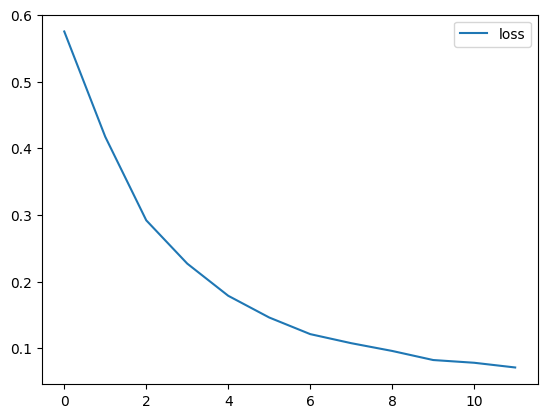

In [52]:
#@title Graphing loss versus validation loss during training

plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [53]:
def translate_sentences(sentences,#=(sources, targets)
                        translation_func, source_tokenizer, encoder,
                        target_tokenizer, decoder):
  translations = {'Tokenized Original': [], 'Reference': [], 'Translation': []}

  for (source, target) in sentences:
    #source, target = s.split(SEPARATOR)
    source = preprocess_text(source)
    tokenized_sentence, translated = translation_func(source, source_tokenizer, encoder,
                                                      target_tokenizer, decoder)

    translations['Tokenized Original'].append(tokenized_sentence)
    translations['Reference'].append(target)
    translations['Translation'].append(translated)

  return translations

def translate_with_attention(sentence: str,
                             source_tokenizer, encoder,
                             target_tokenizer, decoder,
                             max_translated_len = 30):
    input_seq = source_tokenizer.texts_to_sequences([sentence])
    tokenized = source_tokenizer.sequences_to_texts(input_seq)

    input_seq = pad_sequences(input_seq, maxlen=max_encoding_len, padding='post')
    encoder_output, state_h, state_c  = encoder.predict(input_seq)

    current_word = '<sos>'
    decoded_sentence = []

    while len(decoded_sentence) < max_translated_len:
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = target_tokenizer.word_index[current_word]

        logits, state_h, state_c, _ = decoder.predict([target_seq, encoder_output, (state_h, state_c)])
        current_token_index = np.argmax(logits[0])

        current_word = target_tokenizer.index_word[current_token_index]

        if (current_word == '<eos>'):
          break

        decoded_sentence.append(current_word)

    return tokenized[0], ' '.join(decoded_sentence)

In [54]:
shorter_translations_w_attention = pd.DataFrame(translate_sentences(samples_test, translate_with_attention,
                                                                    source_tokenizer, encoder,
                                                                    target_tokenizer, decoder))
shorter_translations_w_attention

1/1 [==============================] - 0s 19ms/step


,Tokenized Original,Reference,Translation
0,no pueden <unk> .,You can't blame them.,they can't fool us .
1,el hombre mayor vivia en el apartamento de tre...,The old man lived in the three-room apartment.,the oldest used to live in the arm of the labo...
2,el me miro fijamente y no dijo nada .,He stared at me and said nothing.,he looked at me and didn't say anything .
3,deberias decir la verdad .,You should tell the truth.,you should say the truth .
4,¿ necesitas mas dinero ?,Do you need more money?,do you need more money ?
...,...,...,...
95,"¿ puedes <unk> a responder a la pregunta , por...",Could you just please answer the question? We ...,"can you please reduce to make the question , p..."
96,"cada vez que lo veo , esta sonriendo .","Every time I see him, he is smiling.","every time i saw him , he orders to be smiling ."
97,es imposible que el se olvidara de nuestra reu...,It's impossible that he forgot our meeting.,he is likely to forget on our meeting .
98,las estrellas no se ven durante el dia .,Stars cannot be seen in the daytime.,stars don't turn off during the day .


In [55]:
!pip install transformers # If you are using collab, "!" is required to download
!pip install bert-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 95.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 872.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [56]:
# import dependencies and load model
from transformers import BertTokenizer, BertForMaskedLM, BertModel
from bert_score import BERTScorer

scorer = BERTScorer(model_type='bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [58]:
candidates = shorter_translations_w_attention["Translation"]
references = shorter_translations_w_attention["Reference"]

In [59]:
def calculate_BERTScores(candidates=candidates, references=references):

  precisions, recalls, f1s = [], [], []

  for i in range(len(references)):
    P, R, F1 = scorer.score([candidates[i]], [references[i]])
    precisions.append(f"{P.mean():.4f}")
    recalls.append(f"{R.mean():.4f}")
    f1s.append(f"{F1.mean():.4f}")

  return precisions, recalls, f1s

In [60]:
ps, rs, fs = calculate_BERTScores()
shorter_translations_w_attention["Precision"] = ps
shorter_translations_w_attention["Recall"] = rs
shorter_translations_w_attention["F1"] = fs

### Loading dataframe

In [61]:
def load_translation_data(data):
  return pd.DataFrame(data)

In [62]:
translations_luong_attn_eval = load_translation_data(shorter_translations_w_attention)
translations_luong_attn_eval.head(10)

,Tokenized Original,Reference,Translation,Precision,Recall,F1
0,no pueden <unk> .,You can't blame them.,they can't fool us .,0.6931,0.6931,0.6931
1,el hombre mayor vivia en el apartamento de tre...,The old man lived in the three-room apartment.,the oldest used to live in the arm of the labo...,0.5362,0.5321,0.5341
2,el me miro fijamente y no dijo nada .,He stared at me and said nothing.,he looked at me and didn't say anything .,0.8124,0.8808,0.8452
3,deberias decir la verdad .,You should tell the truth.,you should say the truth .,0.9104,0.9104,0.9104
4,¿ necesitas mas dinero ?,Do you need more money?,do you need more money ?,1.0000,1.0000,1.0000
5,<unk> .,They'll wait.,keep it .,0.4955,0.4386,0.4653
6,la guerra fria empezo despues de la segunda gu...,The Cold War began after the Second World War.,the cold war began after the second world .,0.9694,0.9471,0.9581
7,¿ que clase de <unk> vendes en tu negocio ?,What kinds of goods do you sell in your shop?,what kind of exercises in your position do you...,0.7372,0.7295,0.7333
8,¿ tienes la boleta ?,Do you have a receipt?,do you have a hug ?,0.7656,0.7656,0.7656
9,creo que es altamente improbable que vuelva a ...,I think it's highly unlikely that I'll ever se...,i think it's highly unlikely that entering me ...,0.6479,0.6842,0.6656


In [63]:
#@title Saving translation history for comparison notebook
SAVED_PKL_PATH = "./luong-attn-translations.pkl"

# Open a file and use dump()
with open(SAVED_PKL_PATH, 'wb') as file:

    # A new file will be created
    pickle.dump(translations_luong_attn_eval, file)